<a href="https://colab.research.google.com/github/1scarecrow1/1scarecrow1/blob/main/BLMonthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib PyPortfolioOpt yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import pypfopt
pypfopt.__version__

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting, EfficientFrontier 

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from datetime import datetime
from dateutil.relativedelta import relativedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "BRK-B", "XOM", "UNH", "JNJ", "JPM", "PG", 
           "HD", "CVX", "LLY", "PEP", "KO", "PFE", "CSCO", "BAC", "MCD", "WMT",
           "ABT", "ADBE", "DHR", "TXN", "CMCSA", "AMD", "VZ", "NKE", "NEE", "WFC",
           "UPS", "QCOM", "T", "ORCL", "HON", "AMGN", "INTC", "LOW", "COP"]

ticker_sub = ["AAPL", "MSFT", "NVDA", "AMZN", "BRK-B", "XOM", "UNH", "JNJ", "JPM", "PG", 
           "HD", "CVX", "LLY", "PEP", "KO", "PFE"]

#Subset of tickers that we want:
#ticker = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'CSCO', 'BAC', 'AMD', 'T', 'INTC']
#Got rid of TSLA, ACN, ABBV, AVGO, V, PM, GOOG, GOOGL, MA, NFLX, LIN
ticker = tickers

start_date = datetime(2000, 1, 1)
end_date = datetime(2022, 12, 31)

#test_dates = pd.date_range(start=test_date, end=end_date, freq = 'M')

ohlc = yf.download(ticker, start = start_date, end = end_date, interval = '1mo')
prices_monthly = ohlc["Open"]

[*********************100%***********************]  39 of 39 completed


In [ ]:
returns_monthly = prices_monthly.pct_change().fillna('0')

In [ ]:
market_prices_monthly = yf.download('SAP', start = start_date, end = end_date, interval = '1mo')['Open']

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

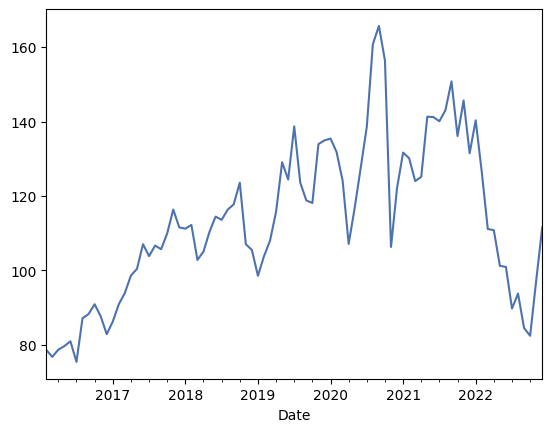

In [ ]:
market_prices_monthly[test_dates].plot()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

mcaps = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Market caps companies.xlsx')
mcaps['Date'] = pd.to_datetime(mcaps['Date'])
mcaps_new = mcaps.set_index('Date')
mcaps_new = mcaps_new[tickers]

Mounted at /content/drive


In [ ]:
riskfree_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Riskfree_rate2.xlsx', parse_dates = True, sheet_name='Day').dropna()
riskfree_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Kopie van Riskfree_rate2.xlsx', parse_dates = True, sheet_name='Week').dropna()
riskfree_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Kopie van Riskfree_rate2.xlsx', parse_dates = True, sheet_name='Month').dropna()

for i in range(0, len(riskfree_daily)):
  riskfree_daily['Date'].loc[i] = datetime.strptime(str(riskfree_daily['Date'].loc[i]), '%Y-%m-%d %H:%M:%S').date()
riskfree_daily = riskfree_daily.set_index('Date')/100

for i in riskfree_weekly.index:
  riskfree_weekly['Date'].loc[i] = datetime.strptime(str(riskfree_weekly['Date'].loc[i]), '%Y%m%d').date()
riskfree_weekly = riskfree_weekly.set_index('Date')/(1000*100)

for i in riskfree_monthly.index:
  riskfree_monthly['Date'].loc[i] = datetime.strptime(str(riskfree_monthly['Date'].loc[i]), '%Y%m').date()
riskfree_monthly = riskfree_monthly.set_index('Date')/100


<ipython-input-7-710b9d7a2feb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riskfree_daily['Date'].loc[i] = datetime.strptime(str(riskfree_daily['Date'].loc[i]), '%Y-%m-%d %H:%M:%S').date()
<ipython-input-7-710b9d7a2feb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riskfree_weekly['Date'].loc[i] = datetime.strptime(str(riskfree_weekly['Date'].loc[i]), '%Y%m%d').date()
<ipython-input-7-710b9d7a2feb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [ ]:
# Views: mean calculated with a rolling window
# Returns: sample mean + MSE

def rolling_mean(window_size, returns):
  rolling_mean = returns.rolling(window_size, min_periods = window_size).mean()
  return rolling_mean.dropna()

def expanding_mean(window_size, returns):
  expanding_mean = returns.expanding().mean()
  return expanding_mean.dropna()

def mse(train_fraction, rolling_mean, returns, new_ticker):
  mse = [mean_squared_error(rolling_mean[t], returns[t]) for t in new_ticker]
  return np.diag(mse)

In [ ]:
#Black Litterman, computing the expected returns
#Timestamp of rebalancing t, views, Q (cov matrix of views), risk free rate, prices, mcaps, N periods per year
#We can change the covariance matrix: now Ledoit wolf
#We can change way in which you compute the efficient frontier portfolio: now max sharpe 

def bl_weights(t, view, view_cov, window_size, rfr, prices, market_prices, mcaps_fun, N):
  delta = black_litterman.market_implied_risk_aversion(market_prices.iloc[market_prices.index.get_loc(t)-window_size:market_prices.index.get_loc(t)-1], frequency = N, risk_free_rate = rfr)
  S = risk_models.risk_matrix(prices.iloc[prices.index.get_loc(t)-window_size:prices.index.get_loc(t)-1], method = 'ledoit_wolf')
  prior = black_litterman.market_implied_prior_returns(market_caps = mcaps_fun, risk_aversion = delta, cov_matrix = S, risk_free_rate = rfr)
  bl = BlackLittermanModel(S, pi = prior, absolute_views = view, omega = view_cov)
  ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov(), weight_bounds=(-1,1))
  print(bl.bl_returns())
  #ef.min_volatility()
  #ef.efficient_return(target_return = 0.0)
  ef.max_sharpe(rfr)

  return pd.Series(ef.clean_weights())

In [ ]:
#Black Litterman, computing the expected returns
#Timestamp of rebalancing t, views, Q (cov matrix of views), risk free rate, prices, mcaps, N periods per year
#We can change the covariance matrix: now Ledoit wolf
#We can change way in which you compute the efficient frontier portfolio: now max sharpe 

def bl_weights_rel(t, view, view_cov, P_matrix, window_size, rfr, prices, market_prices, mcaps_fun, N):
  delta = black_litterman.market_implied_risk_aversion(market_prices.iloc[:market_prices.index.get_loc(t)-1], frequency = N, risk_free_rate = rfr)
  S = risk_models.risk_matrix(prices.iloc[:prices.index.get_loc(t)-1], method = 'ledoit_wolf')
  prior = black_litterman.market_implied_prior_returns(market_caps = mcaps_fun, risk_aversion = delta, cov_matrix = S, risk_free_rate = rfr)
  bl = BlackLittermanModel(S, pi = prior, Q = view, P = P_matrix, omega = view_cov)
  ef = EfficientFrontier(N * bl.bl_returns(), np.sqrt(N) * bl.bl_cov(), weight_bounds=(-1,1))
  ef.efficient_return(target_return = 0.0)
  #ef.max_sharpe(rfr)

  return pd.Series(ef.clean_weights())

In [ ]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x-pivot-timedelta(1)))

In [ ]:
def sharpe_ratio(return_series, N, rf):
  mean = return_series.mean()*N - rf.mean()*N
  sigma = return_series.std()*np.sqrt(N)
  print('mean', return_series.mean()*N, 'stdv', sigma)

  return mean/ sigma

In [ ]:
#Market caps: list with daily market caps
#t: date we want (already the previous one!)
#x: number of stocks we want to invest in 
#Returns list of tickers that should be included 

def top_x_mc(market_caps, t, x):
  market_caps_sorted = market_caps.loc[t].sort_values(ascending=False)
  top_tickers = market_caps_sorted.index.tolist()
  return top_tickers[0:x]

NAIVE EXPANDING WINDOW MONTHLY

In [ ]:
#Compute monthly optimal weights given certain views:
window_size = 12
train_fraction = 0.7
N_monthly = 12
x = 10 #Number of stocks we want to include

test_dates = prices_monthly.index[round(train_fraction*len(prices_monthly.index)):]

print(round(train_fraction*len(prices_monthly.index)))

193


In [ ]:
bl_weights_rm_monthly = pd.DataFrame(index = test_dates, columns = tickers)
count = 0

for t in bl_weights_rm_monthly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rm_monthly.index.tolist()[bl_weights_rm_monthly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = rolling_mean(window_size, returns_monthly[tops].iloc[:returns_monthly.index.get_loc(t)]).iloc[-1]
  view_cov = mse(train_fraction, rolling_mean(window_size, returns_monthly[tops].iloc[:returns_monthly.index.get_loc(t)]), 
                 returns_monthly[tops].iloc[window_size-1:returns_monthly.index.get_loc(t)-1], tops)
  bl_weights_rm_monthly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_monthly['Monthly_pct'].iloc[bl_weights_rm_monthly.index.get_loc(t)], 
                                            prices_monthly[tops], market_prices_monthly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_monthly)
  count = count +1

bl_weights_rm_monthly = bl_weights_rm_monthly.fillna(0)

AAPL     0.032657
MSFT     0.035679
NVDA     0.025306
AMZN     0.072679
BRK-B   -0.003662
XOM     -0.005750
UNH      0.012438
JNJ      0.003487
JPM      0.016369
PG      -0.006573
HD       0.023179
CVX     -0.010442
LLY      0.015280
PEP      0.006701
KO       0.005773
PFE      0.008388
CSCO     0.010071
BAC      0.013994
MCD      0.021660
WMT     -0.020001
ABT      0.002551
ADBE     0.021463
DHR      0.008963
TXN      0.006131
CMCSA    0.005985
AMD      0.016260
VZ       0.005474
NKE      0.021713
NEE      0.001189
WFC      0.011369
UPS     -0.006064
QCOM    -0.014971
T        0.008438
ORCL    -0.002587
HON      0.006150
AMGN     0.010798
INTC     0.007923
LOW      0.010230
COP     -0.022441
dtype: float64
AAPL     0.038876
MSFT     0.052178
XOM     -0.000470
BRK-B    0.001302
JNJ      0.009037
AMZN     0.078605
WFC      0.014874
PG       0.001232
WMT     -0.013503
JPM      0.024570
dtype: float64
AAPL     0.027658
MSFT     0.037045
XOM      0.001156
BRK-B    0.001566
JNJ      0.00795

ValueError: ignored

<Axes: xlabel='Date'>

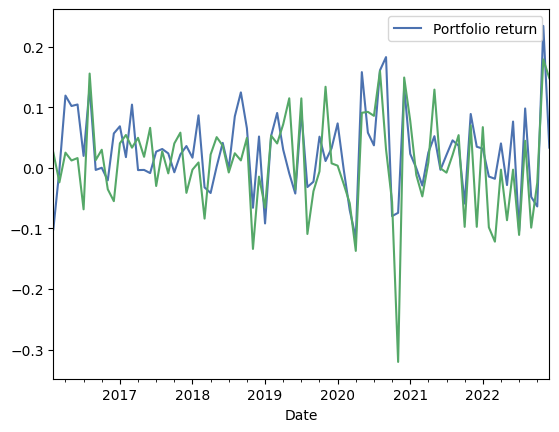

In [ ]:
bl_rm_portfolio_monthly = pd.DataFrame(index = test_dates, columns = ['Portfolio return'])
for t in test_dates:
  bl_rm_portfolio_monthly.loc[t] = np.dot(bl_weights_rm_monthly.loc[t], returns_monthly.loc[t])

bl_rm_portfolio_monthly.plot()
bl_rm_portfolio_monthly.mean()
market_prices_monthly.pct_change().loc[test_dates].plot()

In [ ]:
sr_rm_monthly = sharpe_ratio(bl_rm_portfolio_monthly, N_monthly, riskfree_monthly["Monthly_pct"][193:])
print(sr_rm_monthly)

mean Portfolio return    0.310525
dtype: float64 stdv Portfolio return    0.233016
dtype: float64
Portfolio return    1.290322
dtype: float64


In [ ]:
sr_sp = sharpe_ratio(market_prices_monthly[test_dates].pct_change(), N_monthly, riskfree_monthly["Monthly_pct"][193:])
print(sr_sp)

mean 0.09156884618742911 stdv 0.2794271441735704
0.29241470246290446


NAIVE EXPANDING WINDOW WEEKLY

In [ ]:
#WEEKLY
ohlc_weekly = yf.download(ticker, start = start_date, end = end_date, interval = '1wk')
prices_weekly = ohlc_weekly["Open"]
returns_weekly = prices_weekly.pct_change().fillna('0')
market_prices_weekly = yf.download('SAP', start = start_date, end = end_date, interval = '1wk')['Open']

[*********************100%***********************]  39 of 39 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
window_size = 52
train_fraction = 0.7
N_weekly = 52
x = 39

test_dates_weekly = prices_weekly.index[round(train_fraction*len(prices_weekly.index)):]
print(round(train_fraction*len(prices_weekly.index)))

840


In [ ]:
bl_weights_rm_weekly = pd.DataFrame(index = test_dates_weekly, columns = tickers)

count = 0

for t in bl_weights_rm_weekly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rm_weekly.index.tolist()[bl_weights_rm_weekly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = rolling_mean(window_size, returns_weekly[tops].iloc[:returns_weekly.index.get_loc(nearest(returns_weekly.index.tolist(), t))]).iloc[-1]
  view_cov = mse(train_fraction, rolling_mean(window_size, returns_weekly[tops].iloc[:returns_weekly.index.get_loc(nearest(returns_weekly.index.tolist(), t))-1]), 
            returns_weekly[tops].iloc[window_size:returns_weekly.index.get_loc(nearest(returns_weekly.index.tolist(), t))], tops)
  bl_weights_rm_weekly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_weekly['Weekly'].iloc[bl_weights_rm_weekly.index.get_loc(t)-1], 
                                           prices_weekly[tops], market_prices_weekly, mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_weekly)
  
  bl_weights_rm_weekly = bl_weights_rm_weekly.fillna(0)

/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


<Axes: xlabel='Date'>

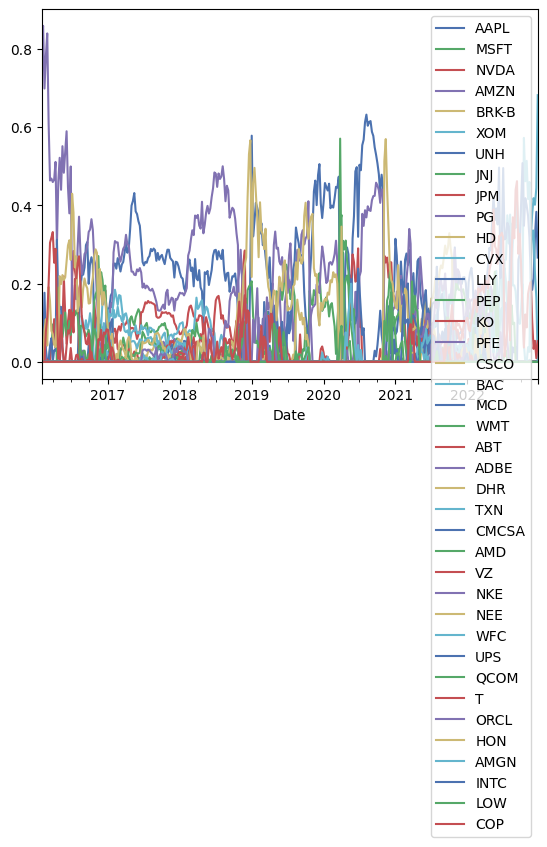

In [ ]:
bl_weights_rm_weekly.plot()

Portfolio return    0.006969
dtype: float64

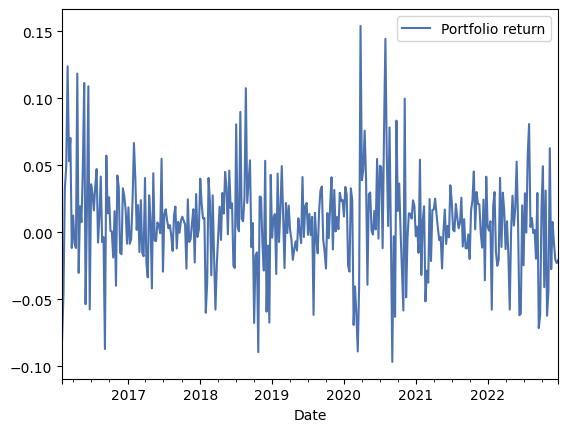

In [ ]:
bl_rm_portfolio_weekly = pd.DataFrame(index = test_dates_weekly, columns = ['Portfolio return'])
for t in test_dates_weekly:
  bl_rm_portfolio_weekly.loc[t] = np.dot(bl_weights_rm_weekly.loc[t], returns_weekly.loc[t])

bl_rm_portfolio_weekly.plot()
bl_rm_portfolio_weekly.mean()

In [ ]:
sr_rm_weekly = sharpe_ratio(bl_rm_portfolio_weekly, N_weekly, riskfree_weekly['Weekly'].iloc[840:])
print(sr_rm_weekly)

mean Portfolio return    0.362381
dtype: float64 stdv Portfolio return    0.259569
dtype: float64
Portfolio return    1.356662
dtype: float64


NAIVE EXPANDING WINDOW DAILY

In [ ]:
#DAILY
ohlc_daily = yf.download(ticker, start = start_date, end = end_date, interval = '1d')
prices_daily = ohlc_daily["Open"]

returns_daily = prices_daily.pct_change().fillna('0')

market_prices_daily = yf.download('SAP', start = start_date, end = end_date, interval = '1d')['Open'].fillna('bfill')

[*********************100%***********************]  39 of 39 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
window_size_daily = 200
train_fraction = 0.7
N_daily = 252
x = 39

test_dates_daily = prices_daily.index[round(train_fraction*len(prices_daily.index)):]

In [ ]:
bl_weights_rm_daily = pd.DataFrame(index = test_dates_daily, columns = tickers)

for t in bl_weights_rm_daily.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rm_daily.index.tolist()[bl_weights_rm_daily.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = rolling_mean(window_size_daily, returns_daily[tops].loc[:t-timedelta(1)]).iloc[-1]
  view_cov = mse(train_fraction, rolling_mean(window_size_daily, returns_daily[tops].loc[:t-timedelta(1)]), returns_daily[tops].iloc[window_size_daily-1:returns_daily.index.get_loc(t)], tops)
  bl_weights_rm_daily.loc[t] = bl_weights(t, view, view_cov, window_size_daily, riskfree_daily['Daily_pct'].iloc[bl_weights_rm_daily.index.get_loc(t)-1], 
                                          prices_daily[tops], market_prices_daily, mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_daily)
  
  bl_weights_rm_daily = bl_weights_rm_daily.fillna(0)

KeyboardInterrupt: ignored

Portfolio return    0.036969
dtype: float64

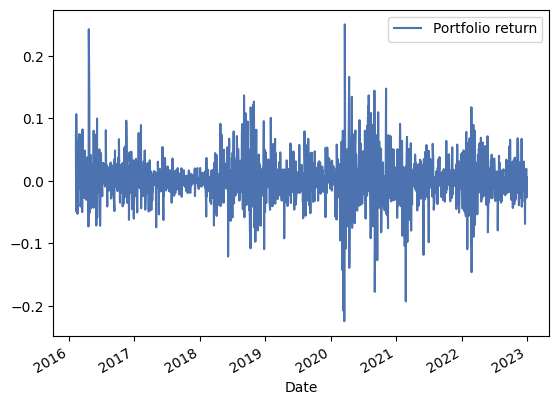

In [ ]:
bl_rm_portfolio_daily = pd.DataFrame(index = test_dates_daily, columns = ['Portfolio return'])
for t in test_dates_daily:
  bl_rm_portfolio_daily.loc[t] = np.dot(bl_weights_rm_daily.loc[t], returns_daily.loc[t])

bl_rm_portfolio_daily.plot()
bl_rm_portfolio_daily.mean()
bl_rm_portfolio_daily.std()

In [ ]:
sr_rm_daily = sharpe_ratio(bl_rm_portfolio_daily, N_daily, riskfree_daily['Daily_pct'][3530:])
print(sr_rm_daily)

mean Portfolio return    0.586035
dtype: float64 stdv Portfolio return    0.586858
dtype: float64
Portfolio return    0.985723
dtype: float64


RANDOM FOREST 

In [ ]:
rf_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RFMonthly.xlsx', 'Predicted').dropna()
rf_monthly_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RFMonthly.xlsx', 'MSE').dropna()

rf_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RFWeekly.xlsx', 'Predictions').dropna()
rf_weekly_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RFWeekly.xlsx', 'MSE').dropna()

rf_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RFDaily.xlsx', 'Predictions').dropna()
rf_daily_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RFDaily.xlsx', 'MSE').dropna()

RANDOM FOREST MONTHLY

In [ ]:
#Random forest monthly 
window_size = 12
train_fraction = 0.7
N_monthly = 12
x = 39

test_dates = prices_monthly.index[round(train_fraction*len(prices_monthly.index))+1:]

In [ ]:
bl_weights_rf_monthly = pd.DataFrame(index = test_dates, columns = tickers)
count = 0

for t in bl_weights_rf_monthly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rf_monthly.index.tolist()[bl_weights_rf_monthly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = rf_monthly[tops].iloc[count]
  view_cov = np.diag(rf_monthly_mse[tops].iloc[count])
  count = count+1
  bl_weights_rf_monthly.loc[t] = bl_weights(t, view, view_cov, window_size, -0.005, 
                                            prices_monthly[tops], market_prices_monthly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_monthly)
  
  #riskfree_monthly['Monthly_pct'].iloc[bl_weights_rf_monthly.index.get_loc(t)-1]
  
  bl_weights_rf_monthly = bl_weights_rf_monthly.fillna(0)

<Axes: xlabel='Date'>

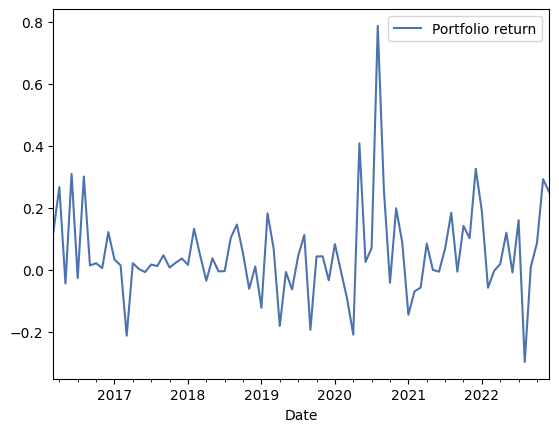

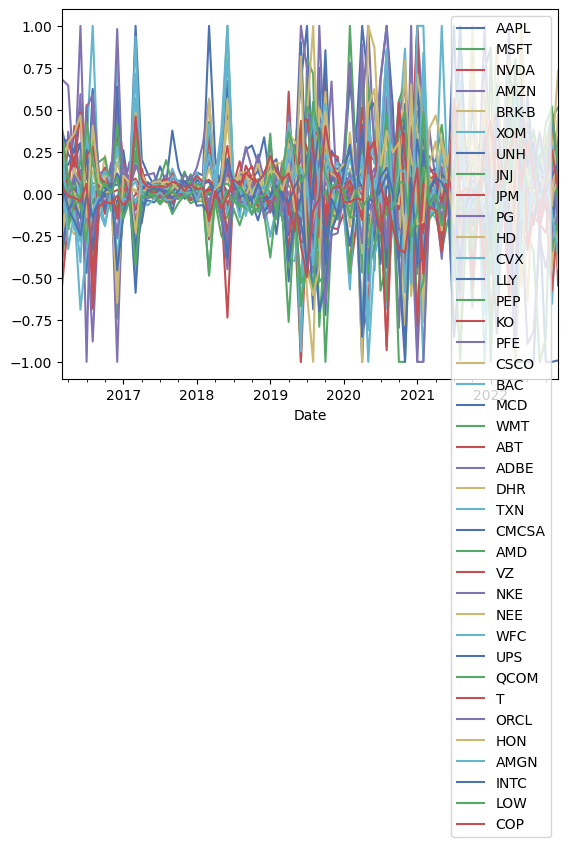

In [ ]:
bl_rf_portfolio_monthly = pd.DataFrame(index = test_dates, columns = ['Portfolio return'])
for t in test_dates:
  bl_rf_portfolio_monthly.loc[t] = np.dot(bl_weights_rf_monthly.loc[t], returns_monthly.loc[t])

bl_rf_portfolio_monthly.plot()
bl_rf_portfolio_monthly.mean()

bl_weights_rf_monthly.plot()

In [ ]:
sr_rf_monthly = sharpe_ratio(bl_rf_portfolio_monthly, N_monthly, riskfree_monthly['Monthly_pct'].iloc[193:])
print(sr_rf_monthly)

mean Portfolio return    0.634994
dtype: float64 stdv Portfolio return    0.519311
dtype: float64
Portfolio return    1.203776
dtype: float64


RANDOM FOREST DAILY

In [ ]:
#Random forest daily
window_size = 200
train_fraction = 0.7
N_daily = 252

test_dates_daily = prices_daily.index[round(train_fraction*len(prices_daily.index))+1:]

In [ ]:
bl_weights_rf_daily = pd.DataFrame(index = test_dates_daily, columns = tickers)
count = 0

for t in bl_weights_rf_daily.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rf_daily.index.tolist()[bl_weights_rf_daily.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = rf_daily[tops].iloc[count]
  view_cov = np.diag(rf_daily_mse[tops].iloc[count])
  count = count+1
  bl_weights_rf_daily.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_daily['Daily '].iloc[bl_weights_rf_daily.index.get_loc(t)-1], 
                                          prices_daily[tops], market_prices_daily[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_daily)
  
  bl_weights_rf_daily = bl_weights_rf_daily.fillna(0)

<Axes: xlabel='Date'>

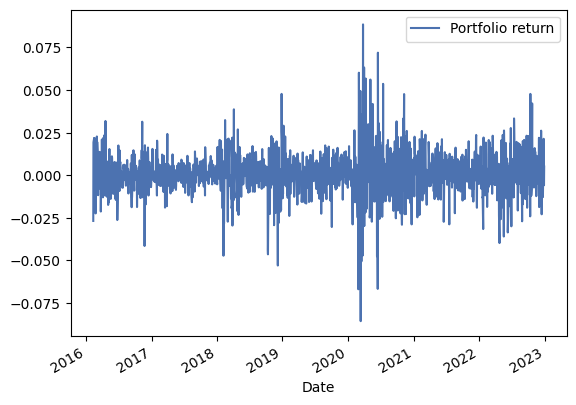

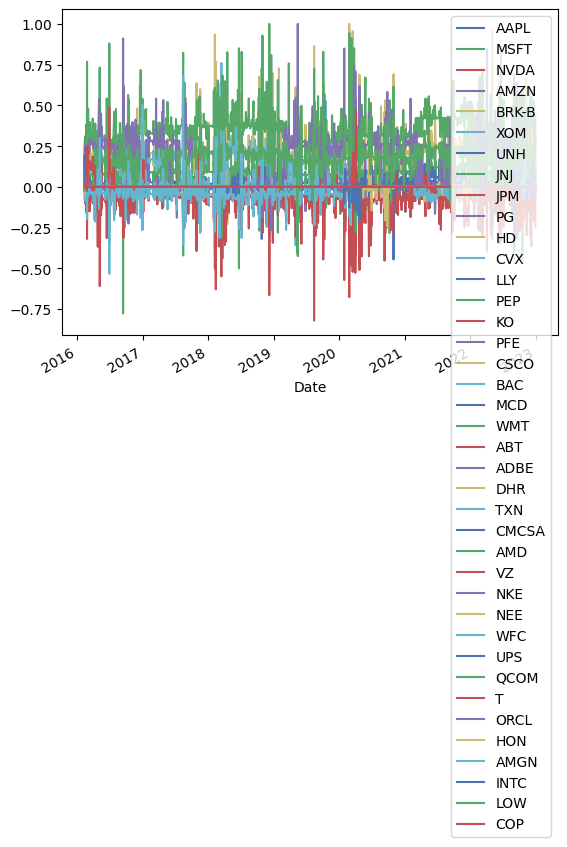

In [ ]:
bl_rf_portfolio_daily = pd.DataFrame(index = test_dates_daily, columns = ['Portfolio return'])
for t in test_dates_daily:
  bl_rf_portfolio_daily.loc[t] = np.dot(bl_weights_rf_daily.loc[t], returns_daily.loc[t])

bl_rf_portfolio_daily.plot()
bl_rf_portfolio_daily.mean()

bl_weights_rf_daily.plot()

In [ ]:
sr_rf_daily = sharpe_ratio(bl_rf_portfolio_daily, N_daily, riskfree_daily['Daily '].iloc[3510:])
print(sr_rf_daily)

mean Portfolio return    0.230275
dtype: float64 stdv Portfolio return    0.198012
dtype: float64
Portfolio return    1.162555
dtype: float64


RANDOM FOREST WEEKLY

In [ ]:
window_size = 50
train_fraction = 0.7
N_weekly = 52

test_dates_weekly = prices_weekly.index[round(train_fraction*len(prices_weekly.index))+1:]

In [ ]:
bl_weights_rf_weekly = pd.DataFrame(index = test_dates_weekly, columns = tickers)
count = 0

for t in bl_weights_rf_weekly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rf_weekly.index.tolist()[bl_weights_rf_weekly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = rf_weekly[tops].iloc[count]
  view_cov = np.diag(rf_weekly_mse[tops].iloc[count])
  count = count+1
  bl_weights_rf_weekly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_weekly['Weekly'].iloc[bl_weights_rf_weekly.index.get_loc(t)-1],
                                           prices_weekly[tops], market_prices_weekly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_weekly)
  
  bl_weights_rf_weekly = bl_weights_rf_weekly.fillna(0)

<Axes: xlabel='Date'>

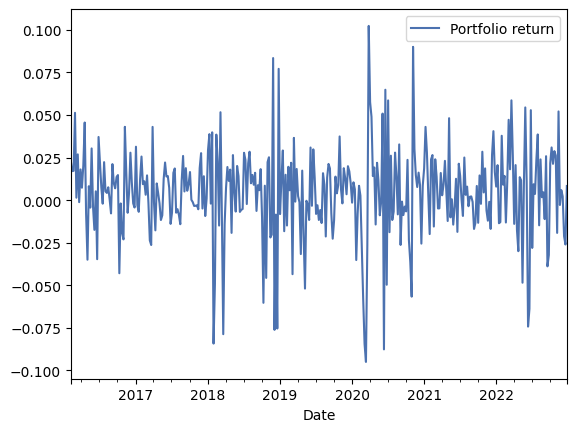

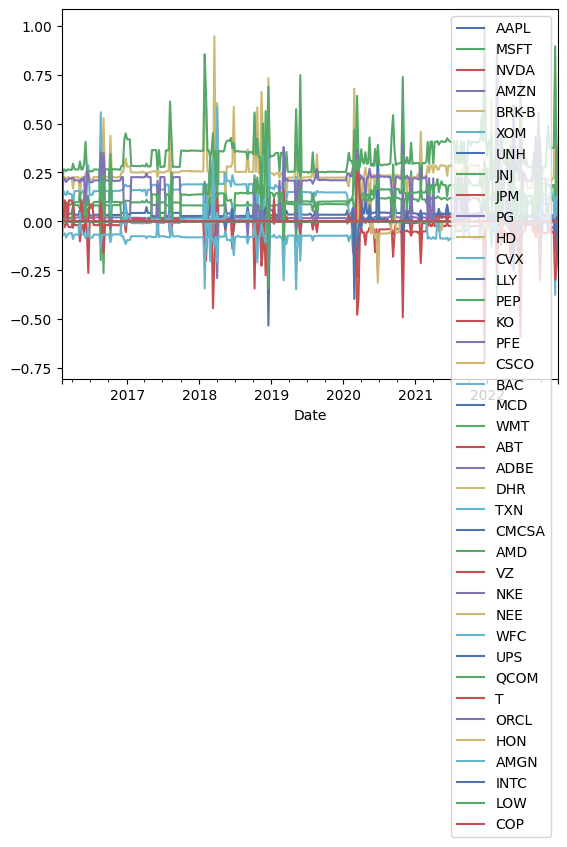

In [ ]:
bl_rf_portfolio_weekly = pd.DataFrame(index = test_dates_weekly, columns = ['Portfolio return'])
for t in test_dates_weekly:
  bl_rf_portfolio_weekly.loc[t] = np.dot(bl_weights_rf_weekly.loc[t], returns_weekly.loc[t])

bl_rf_portfolio_weekly.plot()
bl_rf_portfolio_weekly.mean()

bl_weights_rf_weekly.plot()

In [ ]:
sr_rf_weekly = sharpe_ratio(bl_rf_portfolio_weekly, N_weekly, riskfree_weekly['Weekly'].iloc[840:])
print(sr_rf_weekly)

mean Portfolio return    0.218371
dtype: float64 stdv Portfolio return    0.19047
dtype: float64
Portfolio return    1.092754
dtype: float64


Statistics on the weights

In [ ]:
!pip install XlsxWriter
import xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 14.0 MB/s eta 0:00:00


In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Seminar Investing/BL 25.xlsx', engine='xlsxwriter')

bl_weights_rm_monthly.to_excel(writer, sheet_name='RM Monthly')
bl_weights_rm_weekly.to_excel(writer, sheet_name='RM Weekly')
bl_weights_rm_daily.to_excel(writer, sheet_name='RM Daily')
bl_weights_rf_monthly.to_excel(writer, sheet_name='RF Monthly')
bl_weights_rf_weekly.to_excel(writer, sheet_name='RF Weekly')
bl_weights_rf_daily.to_excel(writer, sheet_name='RF Daily')

bl_rm_portfolio_monthly.to_excel(writer, sheet_name='RM Monthly Port')
bl_rm_portfolio_weekly.to_excel(writer, sheet_name='RM Weekly Port')
bl_rm_portfolio_daily.to_excel(writer, sheet_name='RM Daily Port')
bl_rf_portfolio_monthly.to_excel(writer, sheet_name='RF Monthly Port')
bl_rf_portfolio_weekly.to_excel(writer, sheet_name='RF Weekly Port')
bl_rf_portfolio_daily.to_excel(writer, sheet_name='RF Daily Port')

In [ ]:
writer.close()

Random Forest with up-down predictions

In [ ]:
rfd_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RandomForestMonthlyDirection.xlsx', 'Predictions').dropna()
rfd_monthly_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RandomForestMonthlyDirection.xlsx', 'MSE').dropna()

rfd_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RandomForestWeeklyDirection.xlsx', 'Predictions').dropna()
rfd_weekly_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RandomForestWeeklyDirection.xlsx', 'MSE').dropna()

rfd_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RandomForestDailyDirection.xlsx', 'Predictions').dropna()
rfd_daily_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/RandomForestDailyDirection.xlsx', 'MSE').dropna()

RF Up-Down Monthly

In [ ]:
window = 12
test_dates = prices_monthly.index[round(train_fraction*len(prices_monthly.index))+1:]
view_monthly = pd.DataFrame(index = test_dates, columns = tickers)
count = 0

for t in test_dates:
  #print(t)
  #print((rolling_mean(window, returns_monthly[tickers].iloc[:returns_monthly.index.get_loc(t)]) * rfd_monthly[tickers].iloc[count]).iloc[-1].mean())
  #print(rfd_monthly[tickers].iloc[count])
  exp_return = (rolling_mean(window, returns_monthly[tickers].iloc[:returns_monthly.index.get_loc(t)]) * rfd_monthly[tickers].iloc[count]).iloc[-1].mean()
  view_monthly.loc[t] = rfd_monthly[tickers].iloc[count] * exp_return
  count = count + 1

display(view_monthly)



,AAPL,MSFT,NVDA,AMZN,BRK-B,XOM,UNH,JNJ,JPM,PG,...,WFC,UPS,QCOM,T,ORCL,HON,AMGN,INTC,LOW,COP
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-01,-0.0,-0.0,-0.00032,-0.0,-0.0,-0.00032,-0.00032,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.00032,-0.00032,-0.00032,-0.00032,-0.0,-0.0,-0.0,-0.00032
2016-04-01,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,...,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167,-0.002167
2016-05-01,0.001775,0.0,0.0,0.001775,0.0,0.001775,0.001775,0.001775,0.001775,0.001775,...,0.001775,0.0,0.001775,0.0,0.0,0.001775,0.001775,0.0,0.001775,0.001775
2016-06-01,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,...,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179,0.006179
2016-07-01,0.006748,0.006748,0.006748,0.006748,0.006748,0.006748,0.006748,0.006748,0.0,0.006748,...,0.006748,0.006748,0.006748,0.006748,0.006748,0.006748,0.0,0.006748,0.0,0.006748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,...,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907
2022-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000185,0.0,0.0,0.0


In [ ]:
bl_weights_rfd_monthly = pd.DataFrame(index = test_dates, columns = tickers)
count = 0

for t in bl_weights_rfd_monthly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_rfd_monthly.index.tolist()[bl_weights_rfd_monthly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = view_monthly[tops].iloc[count]
  view_cov = np.diag(rfd_monthly_mse[tops].iloc[count])
  count = count+1
  print(view)
  bl_weights_rfd_monthly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_monthly['Monthly_pct'].iloc[bl_weights_rfd_monthly.index.get_loc(t)-1], 
                                            prices_monthly[tops], market_prices_monthly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_monthly)
  
  bl_weights_rfd_monthly = bl_weights_rfd_monthly.fillna(0)

AAPL        -0.0
MSFT        -0.0
NVDA    -0.00032
AMZN        -0.0
BRK-B       -0.0
XOM     -0.00032
UNH     -0.00032
JNJ         -0.0
JPM         -0.0
PG          -0.0
HD          -0.0
CVX     -0.00032
LLY         -0.0
PEP         -0.0
KO      -0.00032
PFE         -0.0
CSCO    -0.00032
BAC         -0.0
MCD     -0.00032
WMT         -0.0
ABT     -0.00032
ADBE        -0.0
DHR     -0.00032
TXN         -0.0
CMCSA   -0.00032
AMD         -0.0
VZ      -0.00032
NKE         -0.0
NEE     -0.00032
WFC         -0.0
UPS         -0.0
QCOM    -0.00032
T       -0.00032
ORCL    -0.00032
HON     -0.00032
AMGN        -0.0
INTC        -0.0
LOW         -0.0
COP     -0.00032
Name: 2016-03-01 00:00:00, dtype: object
AAPL    -0.002167
MSFT    -0.002167
XOM     -0.002167
BRK-B   -0.002167
JNJ     -0.002167
AMZN    -0.002167
WFC     -0.002167
PG      -0.002167
JPM     -0.002167
VZ      -0.002167
Name: 2016-04-01 00:00:00, dtype: object


ValueError: ignored

FAMA FRENCH EXPANDING WINDOW, MONTHLY

In [ ]:
# Read all sheets in the Excel file 
FF3_EW_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/FF_5_m_expanding_window.xlsx.xlsx', sheet_name=None, index_col = 0)

In [ ]:
#FF 3 factors, monthly, expanding window
window_size = 12
train_fraction = 0.7
N_monthly = 12
x = 10

test_dates = prices_monthly.index[round(train_fraction*len(prices_monthly.index))+1:]

In [ ]:
bl_weights_ff3ew_monthly = pd.DataFrame(index = test_dates, columns = tickers)
count = 0

for t in bl_weights_ff3ew_monthly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_ff3ew_monthly.index.tolist()[bl_weights_ff3ew_monthly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = {}
  view_cov = pd.Series(index = tops, dtype = 'float')
  for stock in tops:
    view[stock] = FF3_EW_monthly.get(stock)['Predicted_return'].loc[t]
    view_cov[stock] = FF3_EW_monthly.get(stock)['MSE'].loc[t]
  view_cov = np.diag(view_cov)
  count = count+1
  bl_weights_ff3ew_monthly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_monthly['Monthly_pct'].iloc[bl_weights_ff3ew_monthly.index.get_loc(t)-1], 
                                            prices_monthly[tops], market_prices_monthly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_monthly)
  
  bl_weights_ff3ew_monthly = bl_weights_ff3ew_monthly.fillna(0)

<Axes: xlabel='Date'>

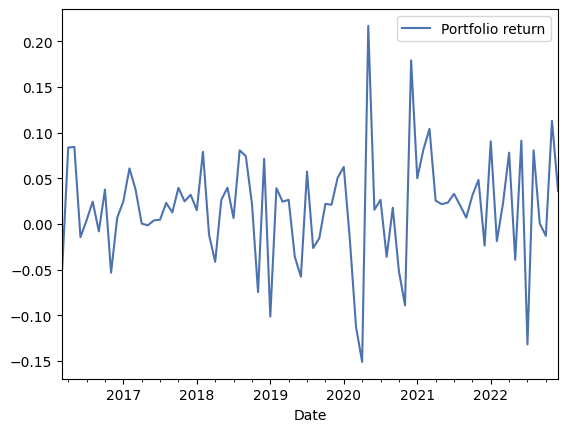

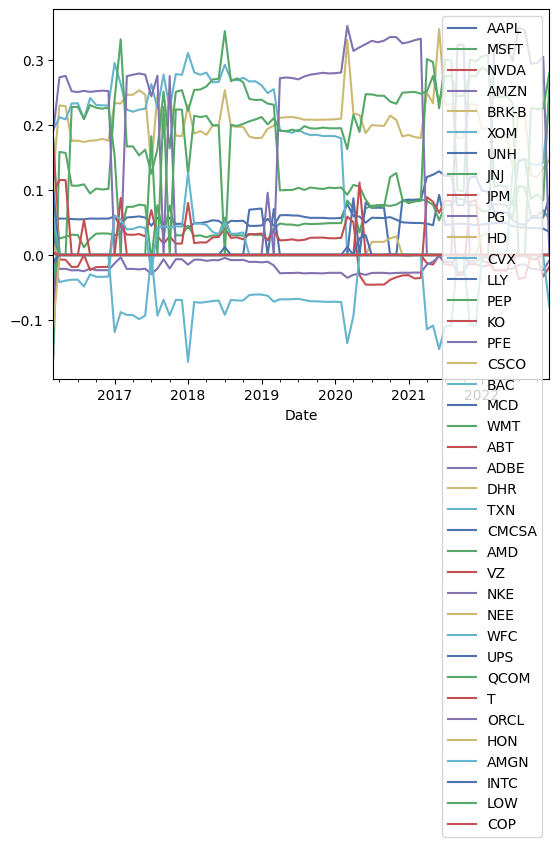

In [ ]:
bl_ff3ew_portfolio_monthly = pd.DataFrame(index = test_dates, columns = ['Portfolio return'])
for t in test_dates:
  bl_ff3ew_portfolio_monthly.loc[t] = np.dot(bl_weights_ff3ew_monthly.loc[t], returns_monthly.loc[t])

bl_ff3ew_portfolio_monthly.plot()
bl_ff3ew_portfolio_monthly.mean()

bl_weights_ff3ew_monthly.plot()

In [ ]:
sr_ff3ew_monthly = sharpe_ratio(bl_ff3ew_portfolio_monthly, N_monthly, riskfree_monthly['Monthly_pct'].iloc[193:])
print(sr_ff3ew_monthly)

mean Portfolio return    0.213936
dtype: float64 stdv Portfolio return    0.206335
dtype: float64
Portfolio return    0.989053
dtype: float64


FAMA FRENCH 3 EXPANDING WINDOW, WEEKLY

In [ ]:
# Read all sheets in the Excel file 
FF3_EW_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/FF_5_w_expanding_window.xlsx.xlsx', sheet_name=None, index_col = 0)

FileNotFoundError: ignored

In [ ]:
#FF 3 factors, weekly, expanding window
window_size = 50
train_fraction = 0.7
N_weekly= 52
x = 39

test_dates_weekly = prices_weekly.index[round(train_fraction*len(prices_weekly.index))+1:]

In [ ]:
bl_weights_ff3ew_weekly = pd.DataFrame(index = test_dates_weekly, columns = tickers)
count = 0

for t in bl_weights_ff3ew_weekly.index:
  print(t)
  tops = tickers
  if count > 0:
    ago = bl_weights_ff3ew_weekly.index.tolist()[bl_weights_ff3ew_weekly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = {}
  view_cov = pd.Series(index = tops, dtype = 'float')
  for stock in tops:
    #nearest(FF3_EW_weekly.get(stock).index.tolist(), 
    #nearest(FF3_EW_weekly.get(stock).index.tolist(), t)
    view[stock] = FF3_EW_weekly.get(stock)['Predicted_return'].loc[t]
    view_cov[stock] = FF3_EW_weekly.get(stock)['MSE'].loc[t]
  view_cov = np.diag(view_cov)
  print(view)
  count = count+1
  bl_weights_ff3ew_weekly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_weekly['Weekly'].iloc[bl_weights_ff3ew_weekly.index.get_loc(t)-1], 
                                            prices_weekly[tops], market_prices_weekly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_weekly)
  
  bl_weights_ff3ew_weekly = bl_weights_ff3ew_weekly.fillna(0)

2016-02-13 00:00:00
{'AAPL': -0.004294707031641488, 'MSFT': -0.003301457469251334, 'NVDA': -0.005788497536643087, 'AMZN': -0.005598167139973876, 'BRK-B': -0.001801536431552444, 'XOM': -0.002707728712805843, 'UNH': -0.003668153308119513, 'JNJ': -0.002261276607667474, 'JPM': -0.006033464187409457, 'PG': -0.0009305135489196311, 'HD': -0.00530548717443334, 'CVX': -0.006599267352280689, 'LLY': -0.0008655001342185145, 'PEP': -0.001303936830562083, 'KO': -0.001138366130643415, 'PFE': -0.002957507433245643, 'CSCO': -0.003426527586218676, 'BAC': -0.006052757402048701, 'MCD': -0.002619094492067586, 'WMT': -0.001710554889931218, 'ABT': -0.002502480605773102, 'ADBE': -0.003022364113701192, 'DHR': -0.002923206069126365, 'TXN': -0.003209614715852924, 'CMCSA': -0.001025715978848437, 'AMD': -0.0124746231424779, 'VZ': -0.001617547710465603, 'NKE': -0.003453103665395353, 'NEE': 0.0006591519413167554, 'WFC': -0.004191163688807467, 'UPS': -0.002931204989253086, 'QCOM': 0.0001703230419303445, 'T': -0.00102

<Axes: xlabel='Date'>

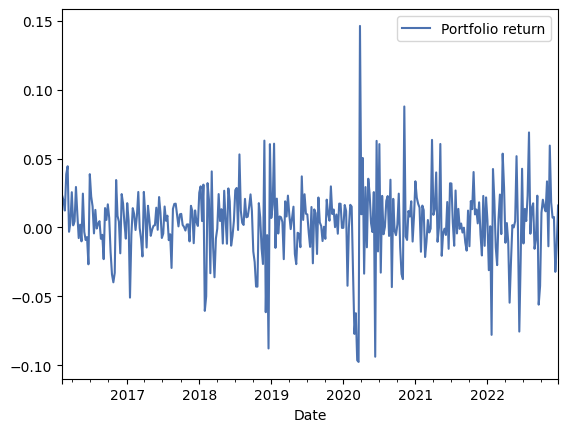

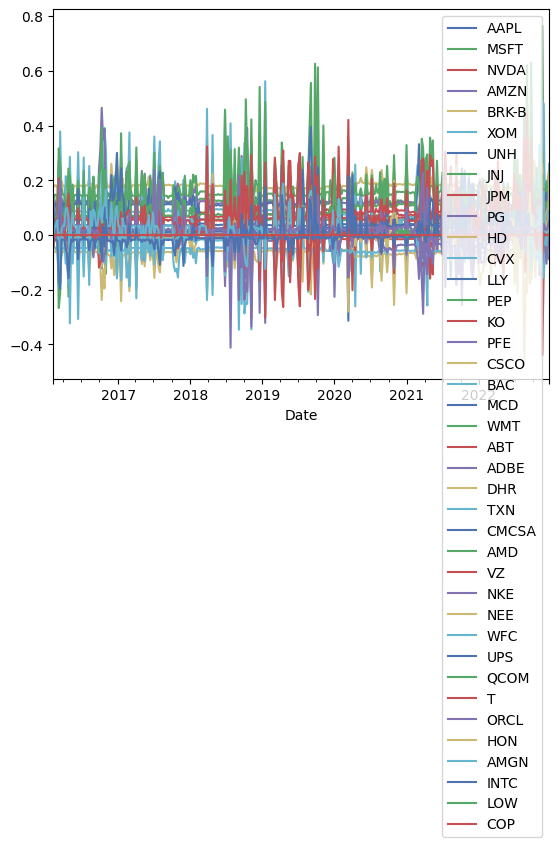

In [ ]:
bl_ff3ew_portfolio_weekly = pd.DataFrame(index = test_dates_weekly, columns = ['Portfolio return'])
for t in test_dates_weekly:
  bl_ff3ew_portfolio_weekly.loc[t] = np.dot(bl_weights_ff3ew_weekly.loc[t], returns_weekly.loc[t])

bl_ff3ew_portfolio_weekly.plot()
bl_ff3ew_portfolio_weekly.mean()

bl_weights_ff3ew_weekly.plot()

In [ ]:
sr_ff3ew_weekly = sharpe_ratio(bl_ff3ew_portfolio_weekly, N_weekly, riskfree_weekly['Weekly'].iloc[840:])
print(sr_ff3ew_weekly)

mean Portfolio return    0.182773
dtype: float64 stdv Portfolio return    0.192369
dtype: float64
Portfolio return    0.896912
dtype: float64


FAMA FRENCH 3 Expanding Window, Daily

In [ ]:
# Read all sheets in the Excel file 
FF3_EW_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/FF_5_d_rolling_window2.xlsx', sheet_name=None, index_col = 0)

In [ ]:
#FF 3 factors, weekly, expanding window
window_size = 200
train_fraction = 0.7
N_daily= 252
x = 10
test_dates_daily = prices_daily.index[round(train_fraction*len(prices_daily.index))+1:]

In [ ]:
bl_weights_ff3ew_daily = pd.DataFrame(index = test_dates_daily, columns = tickers)
count = 0

for t in bl_weights_ff3ew_daily.index:
  tops = tickers
  print(t)
  if count > 0:
    ago = bl_weights_ff3ew_daily.index.tolist()[bl_weights_ff3ew_daily.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = {}
  view_cov = pd.Series(index = tops, dtype = 'float')
  for stock in tops:
    view[stock] = FF3_EW_daily.get(stock)['Predicted_return'].loc[t]
    view_cov[stock] = FF3_EW_daily.get(stock)['MSE'].loc[t]
  view_cov = np.diag(view_cov)
  count = count+1
  bl_weights_ff3ew_daily.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_daily['Daily '].iloc[bl_weights_ff3ew_daily.index.get_loc(t)-1], 
                                            prices_daily[tops], market_prices_daily[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_daily)
  
  bl_weights_ff3ew_daily = bl_weights_ff3ew_daily.fillna(0)

2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-29 00:00:00
2016-03-01 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-04 00:00:00
2016-04-05 00:00:00
2016-04-06 00:00:00
2016-04-07 00:00:00
2016-04-08 00:00:00
2016-04-11 00:00:00
2016-04-12 00:00:00
2016-04-13 00:00:00
2016-04-14 00:00:00
2016-04-15 00:00:00
2016-04-18 00:00:00
2016-04-19 00:00:00
2016-04-20 00:00:00
2016-04-21 00:00:00
2016-04-22 00:00:00


<Axes: xlabel='Date'>

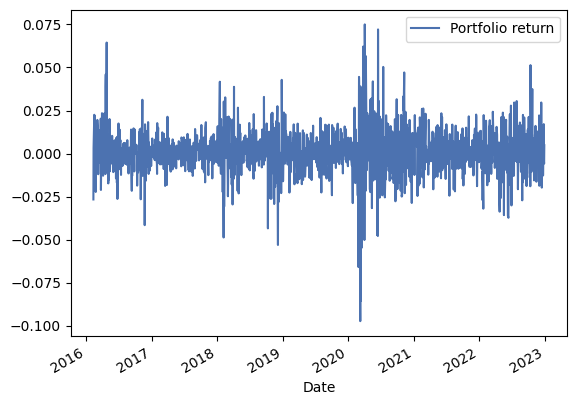

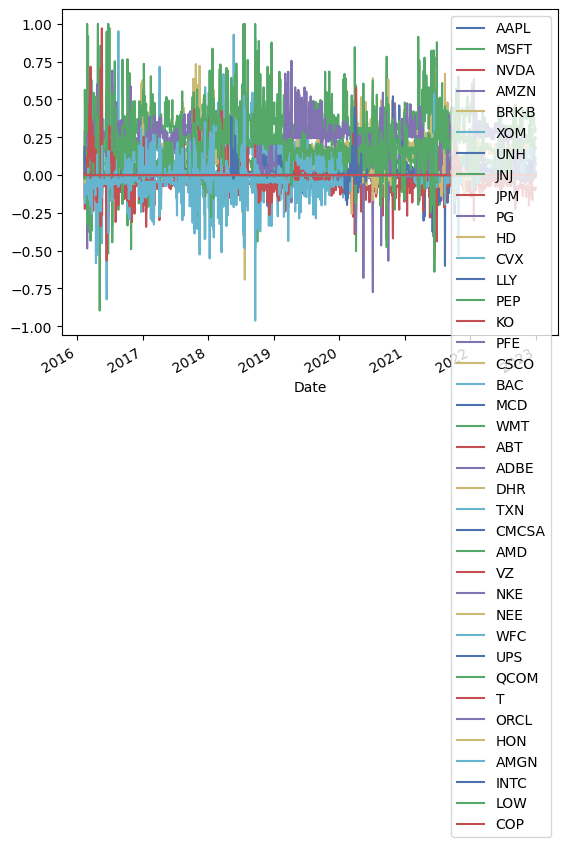

In [ ]:
bl_ff3ew_portfolio_daily = pd.DataFrame(index = test_dates_daily, columns = ['Portfolio return'])
for t in test_dates_daily:
  bl_ff3ew_portfolio_daily.loc[t] = np.dot(bl_weights_ff3ew_daily.loc[t], returns_daily.loc[t])

bl_ff3ew_portfolio_daily.plot()
bl_ff3ew_portfolio_daily.mean()

bl_weights_ff3ew_daily.plot()

In [ ]:
sr_ff3ew_daily = sharpe_ratio(bl_ff3ew_portfolio_daily, N_daily, riskfree_daily['Daily '].iloc[3510:])
print(sr_ff3ew_daily)

mean Portfolio return    0.239105
dtype: float64 stdv Portfolio return    0.204106
dtype: float64
Portfolio return    1.171108
dtype: float64


In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Seminar Investing/BL FF3 EW LW 25.xlsx', engine='xlsxwriter')

bl_weights_ff3ew_monthly.to_excel(writer, sheet_name='FF3EW Monthly')
bl_weights_ff3ew_weekly.to_excel(writer, sheet_name='FF3EW Weekly')
bl_weights_ff3ew_daily.to_excel(writer, sheet_name='FF3EW Daily')

bl_ff3ew_portfolio_monthly.to_excel(writer, sheet_name='FF3EW Monthly Port')
bl_ff3ew_portfolio_weekly.to_excel(writer, sheet_name='FF3EW Weekly Port')
bl_ff3ew_portfolio_daily.to_excel(writer, sheet_name='FF3EW Daily Port')

In [ ]:
writer.close()

LSTM 

In [ ]:
lstm_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/LSTMMonthly.xlsx', 'Predictions').dropna()
lstm_monthly_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/LSTMMonthly.xlsx', 'MSE').dropna()

lstm_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/LSTMWeekly.xlsx', 'Predictions').dropna()
lstm_weekly_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/LSTMWeekly.xlsx', 'MSE').dropna()

lstm_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/LSTMDaily.xlsx', 'Predictions').dropna()
lstm_daily_mse = pd.read_excel('/content/drive/MyDrive/Seminar Investing/LSTMDaily.xlsx', 'MSE').dropna()

LSTM Monthly

In [ ]:
#LSTM monthly 
window_size = 12
train_fraction = 0.7
N_monthly = 12
x = 25

test_dates = prices_monthly.index[round(train_fraction*len(prices_monthly.index))+1:]

In [ ]:
bl_weights_lstm_monthly = pd.DataFrame(index = test_dates, columns = tickers)
count = 0

for t in bl_weights_lstm_monthly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_lstm_monthly.index.tolist()[bl_weights_lstm_monthly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = lstm_monthly[tops].iloc[count]
  view_cov = np.diag(lstm_monthly_mse[tops].iloc[count])
  count = count+1
  bl_weights_lstm_monthly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_monthly['Monthly_pct'].iloc[bl_weights_lstm_monthly.index.get_loc(t)-1], 
                                            prices_monthly[tops], market_prices_monthly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_monthly)
  
  bl_weights_lstm_monthly = bl_weights_lstm_monthly.fillna(0)

<Axes: xlabel='Date'>

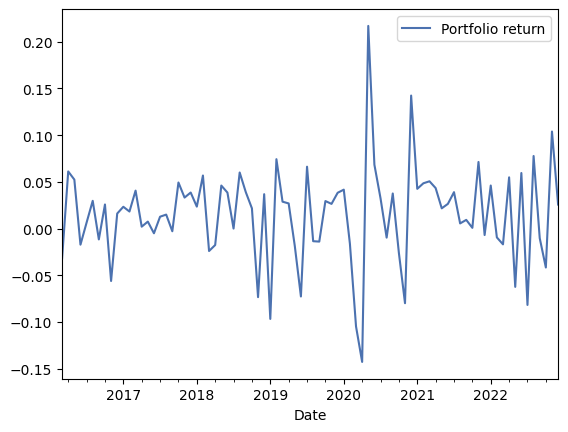

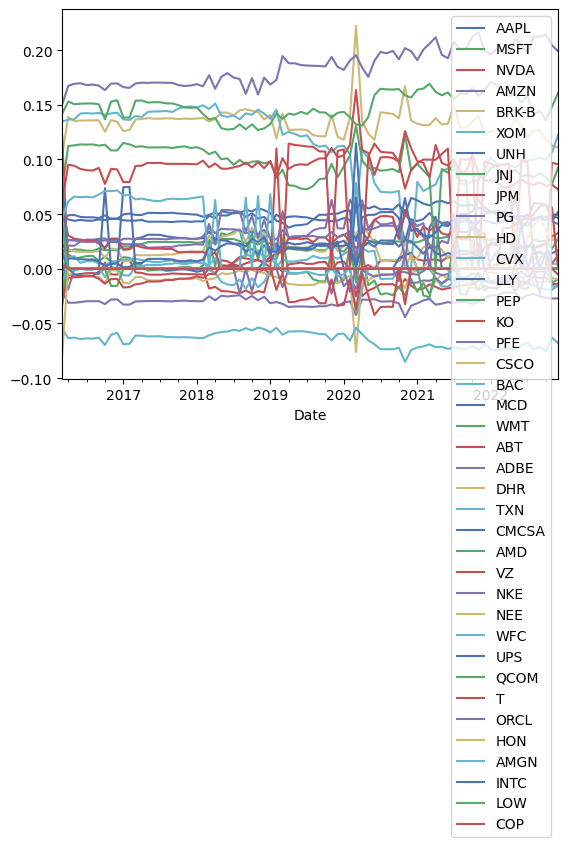

In [ ]:
bl_lstm_portfolio_monthly = pd.DataFrame(index = test_dates, columns = ['Portfolio return'])
for t in test_dates:
  bl_lstm_portfolio_monthly.loc[t] = np.dot(bl_weights_lstm_monthly.loc[t], returns_monthly.loc[t])

bl_lstm_portfolio_monthly.plot()
bl_lstm_portfolio_monthly.mean()

bl_weights_lstm_monthly.plot()

In [ ]:
sr_lstm_monthly = sharpe_ratio(bl_lstm_portfolio_monthly, N_monthly, riskfree_monthly['Monthly_pct'].iloc[193:])
print(sr_lstm_monthly)

mean Portfolio return    0.183062
dtype: float64 stdv Portfolio return    0.181601
dtype: float64
Portfolio return    0.953748
dtype: float64


LSTM Weekly

In [ ]:
window_size = 50
train_fraction = 0.7
N_weekly = 52
x  = 25

test_dates_weekly = prices_weekly.index[round(train_fraction*len(prices_weekly.index))+1:]

In [ ]:
bl_weights_lstm_weekly = pd.DataFrame(index = test_dates_weekly, columns = tickers)
count = 0

for t in bl_weights_lstm_weekly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_lstm_weekly.index.tolist()[bl_weights_lstm_weekly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = lstm_weekly[tops].iloc[count]
  view_cov = np.diag(lstm_weekly_mse[tops].iloc[count])
  count = count+1
  bl_weights_lstm_weekly.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_weekly['Weekly'].iloc[bl_weights_lstm_weekly.index.get_loc(t)-1],
                                           prices_weekly[tops], market_prices_weekly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_weekly)
  
  bl_weights_lstm_weekly = bl_weights_lstm_weekly.fillna(0)

<Axes: xlabel='Date'>

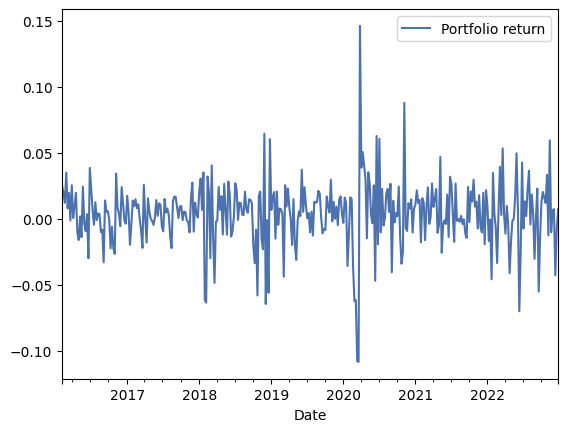

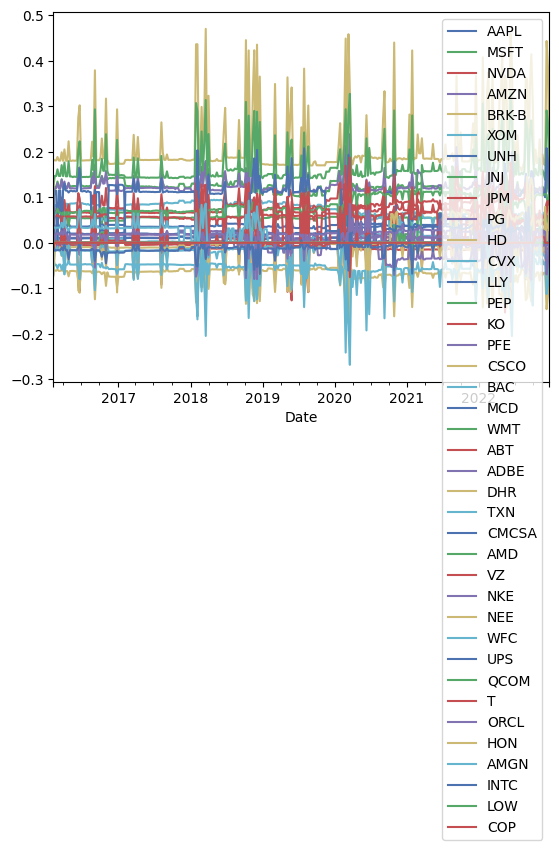

In [ ]:
bl_lstm_portfolio_weekly = pd.DataFrame(index = test_dates_weekly, columns = ['Portfolio return'])
for t in test_dates_weekly:
  bl_lstm_portfolio_weekly.loc[t] = np.dot(bl_weights_lstm_weekly.loc[t], returns_weekly.loc[t])

bl_lstm_portfolio_weekly.plot()
bl_lstm_portfolio_weekly.mean()

bl_weights_lstm_weekly.plot()

In [ ]:
sr_lstm_weekly = sharpe_ratio(bl_lstm_portfolio_weekly, N_weekly, riskfree_weekly['Weekly'].iloc[840:])
print(sr_lstm_weekly)

mean Portfolio return    0.200981
dtype: float64 stdv Portfolio return    0.176985
dtype: float64
Portfolio return    1.077754
dtype: float64


LSTM Daily

In [ ]:
#LSTM daily
window_size = 200
train_fraction = 0.7
N_daily = 252
x = 25

test_dates_daily = prices_daily.index[round(train_fraction*len(prices_daily.index))+1:]

In [ ]:
bl_weights_lstm_daily = pd.DataFrame(index = test_dates_daily, columns = tickers)
count = 0

for t in bl_weights_lstm_daily.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_lstm_daily.index.tolist()[bl_weights_lstm_daily.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = lstm_daily[tops].iloc[count]
  view_cov = np.diag(lstm_daily_mse[tops].iloc[count])
  count = count+1
  bl_weights_lstm_daily.loc[t] = bl_weights(t, view, view_cov, window_size, riskfree_daily['Daily '].iloc[bl_weights_lstm_daily.index.get_loc(t)-1], 
                                          prices_daily[tops], market_prices_daily[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_daily)
  
  bl_weights_lstm_daily = bl_weights_lstm_daily.fillna(0)

<Axes: xlabel='Date'>

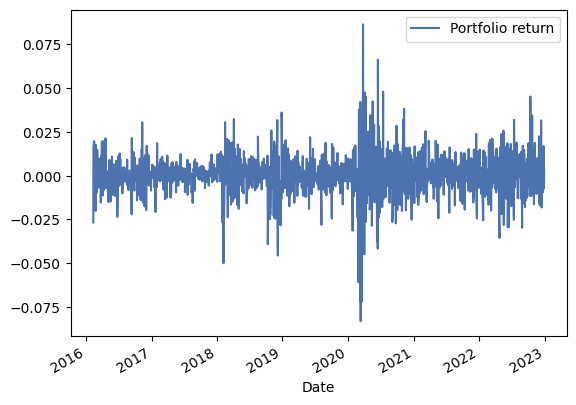

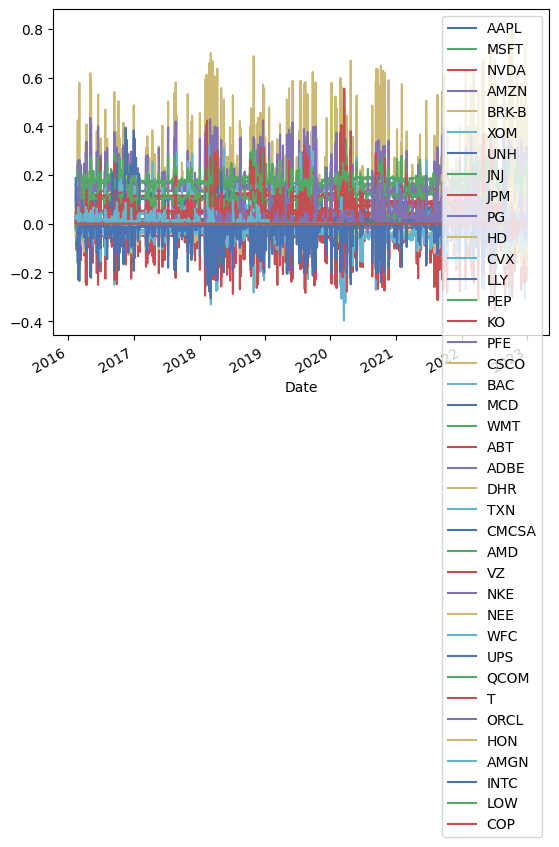

In [ ]:
bl_lstm_portfolio_daily = pd.DataFrame(index = test_dates_daily, columns = ['Portfolio return'])
for t in test_dates_daily:
  bl_lstm_portfolio_daily.loc[t] = np.dot(bl_weights_lstm_daily.loc[t], returns_daily.loc[t])

bl_lstm_portfolio_daily.plot()
bl_lstm_portfolio_daily.mean()

bl_weights_lstm_daily.plot()

In [ ]:
sr_lstm_daily = sharpe_ratio(bl_lstm_portfolio_daily, N_daily, riskfree_daily['Daily '].iloc[3510:])
print(sr_lstm_daily)

mean Portfolio return    0.190191
dtype: float64 stdv Portfolio return    0.181833
dtype: float64
Portfolio return    1.045553
dtype: float64


In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Seminar Investing/BL LSTM LW 25.xlsx', engine='xlsxwriter')

bl_weights_lstm_monthly.to_excel(writer, sheet_name='LSTM Monthly')
bl_weights_lstm_weekly.to_excel(writer, sheet_name='LSTM Weekly')
bl_weights_lstm_daily.to_excel(writer, sheet_name='LSTM Daily')

bl_lstm_portfolio_monthly.to_excel(writer, sheet_name='LSTM Monthly Port')
bl_lstm_portfolio_weekly.to_excel(writer, sheet_name='LSTM Weekly Port')
bl_lstm_portfolio_daily.to_excel(writer, sheet_name='LSTM Daily Port')

In [ ]:
writer.close()

NAIVE RELATIVE VIEWS Monthly

In [ ]:
P_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Naive_P_matrix_monthly.xlsx', index_col = 0)
nr_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/views_matrix_monthly.xlsx', index_col = 0)
nr_uncertainty_monthly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/uncertainty_matrix_monthly.xlsx', index_col = 0)

P_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Naive_P_matrix_weekly.xlsx', index_col = 0)
nr_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/views_matrix_weekly.xlsx', index_col = 0)
nr_uncertainty_weekly = pd.read_excel('/content/drive/MyDrive/Seminar Investing/uncertainty_matrix_weekly.xlsx', index_col = 0)

P_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/Naive_P_matrix_daily.xlsx', index_col = 0)
nr_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/views_matrix_daily.xlsx', index_col = 0)
nr_uncertainty_daily = pd.read_excel('/content/drive/MyDrive/Seminar Investing/uncertainty_matrix_daily.xlsx', index_col = 0)

In [ ]:
#Naive relative monthly 
window_size = 12
train_fraction = 0.7
N_monthly = 12
x = 10

test_dates = prices_monthly.index[round(train_fraction*len(prices_monthly.index))+1:]

In [ ]:
#Black Litterman, computing the expected returns
#Timestamp of rebalancing t, views, Q (cov matrix of views), risk free rate, prices, mcaps, N periods per year
#We can change the covariance matrix: now Ledoit wolf
#We can change way in which you compute the efficient frontier portfolio: now max sharpe 

def bl_weights_rel(t, view, view_cov, P_matrix, window_size, rfr, prices, market_prices, mcaps_fun, N):
  delta = black_litterman.market_implied_risk_aversion(market_prices.iloc[:market_prices.index.get_loc(t)-1], frequency = N, risk_free_rate = rfr)
  S = risk_models.risk_matrix(prices.iloc[:prices.index.get_loc(t)-1], method = 'sample_cov')
  prior = black_litterman.market_implied_prior_returns(market_caps = mcaps_fun, risk_aversion = delta, cov_matrix = S, risk_free_rate = rfr)
  bl = BlackLittermanModel(S, pi = prior, Q = view, P = P_matrix, omega = view_cov)
  ef = EfficientFrontier(N * bl.bl_returns(), np.sqrt(N) * bl.bl_cov(), weight_bounds=(-1,1))
  ef.efficient_return(target_return = 0.0)
  #ef.max_sharpe(rfr)

  return pd.Series(ef.clean_weights())

In [ ]:
bl_weights_nr_monthly = pd.DataFrame(index = test_dates, columns = tickers)
print(bl_weights_nr_monthly)
count = 0
nr_uncertainty_monthly['Average'] = pd.Series(0)
nr_uncertainty_monthly['Average'] = nr_uncertainty_monthly.mean(axis=1)

for t in bl_weights_nr_monthly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_nr_monthly.index.tolist()[bl_weights_nr_monthly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = nr_monthly.loc[t]
  view_cov = np.array(nr_uncertainty_monthly['Average'].loc[t])
  view_cov = np.array([view_cov]).reshape(-1, 1)
  P = P_monthly[tops].loc[t].to_frame()
  count = count+1
  bl_weights_nr_monthly.loc[t] = bl_weights_rel(t, view, view_cov, P.transpose(), window_size, riskfree_monthly['Monthly_pct'].iloc[bl_weights_nr_monthly.index.get_loc(t)-1], 
                                            prices_monthly[tops], market_prices_monthly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_monthly)
  
  bl_weights_nr_monthly = bl_weights_nr_monthly.fillna(0)

           AAPL MSFT NVDA AMZN BRK-B  XOM  UNH  JNJ  JPM   PG  ...  WFC  UPS  \
Date                                                           ...             
2016-03-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2016-04-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2016-05-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2016-06-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2016-07-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
...         ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022-08-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2022-09-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2022-10-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2022-11-01  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2022-12-01  NaN  NaN  NaN  NaN   NaN  Na

<Axes: xlabel='Date'>

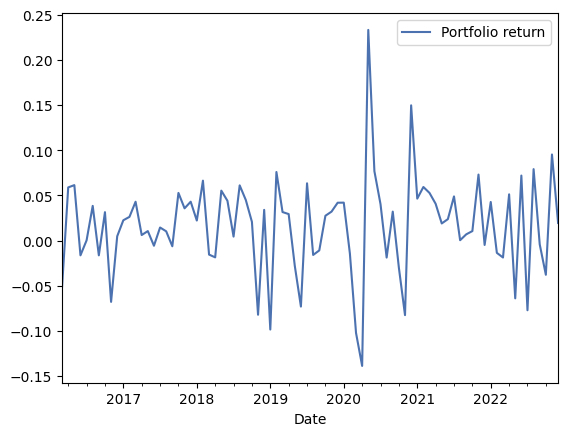

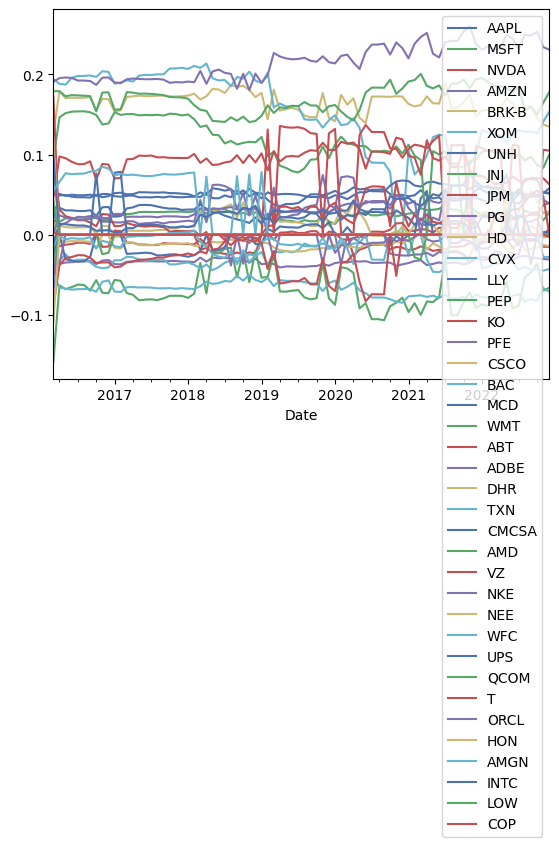

In [ ]:
bl_nr_portfolio_monthly = pd.DataFrame(0, index = test_dates, columns = ['Portfolio return'])
for t in test_dates:
  bl_nr_portfolio_monthly.loc[t] = np.dot(bl_weights_nr_monthly.loc[t], returns_monthly.loc[t])

bl_nr_portfolio_monthly.plot()
bl_nr_portfolio_monthly.mean()

bl_weights_nr_monthly.plot()

In [ ]:
sr_nr_monthly = sharpe_ratio(bl_nr_portfolio_monthly, N_monthly, riskfree_monthly['Monthly_pct'].iloc[193:])
print(sr_nr_monthly)

mean Portfolio return    0.192243
dtype: float64 stdv Portfolio return    0.189728
dtype: float64
Portfolio return    0.961282
dtype: float64


Naive Relative Weekly

In [ ]:
window_size = 50
train_fraction = 0.7
N_weekly = 52
x  = 10

test_dates_weekly = prices_weekly.index[round(train_fraction*len(prices_weekly.index))+1:]

In [ ]:
bl_weights_nr_weekly = pd.DataFrame(index = test_dates_weekly, columns = tickers)
count = 0
nr_uncertainty_weekly['Average'] = pd.Series(0)
nr_uncertainty_weekly['Average'] = nr_uncertainty_weekly.mean(axis=1)

for t in bl_weights_nr_weekly.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_nr_weekly.index.tolist()[bl_weights_nr_weekly.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = nr_weekly.loc[t+timedelta(days=2)]
  view_cov = np.array(nr_uncertainty_weekly['Average'].loc[t+timedelta(days=2)])
  view_cov = np.array([view_cov]).reshape(-1, 1)
  P = P_weekly[tops].loc[t+timedelta(days=2)].to_frame()
  count = count+1
  bl_weights_nr_weekly.loc[t] = bl_weights_rel(t, view, view_cov, P.transpose(), window_size, riskfree_weekly['Weekly'].iloc[bl_weights_nr_weekly.index.get_loc(t)-1], 
                                            prices_weekly[tops], market_prices_weekly[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_weekly)
  
  bl_weights_nr_weekly = bl_weights_nr_weekly.fillna(0)

<Axes: xlabel='Date'>

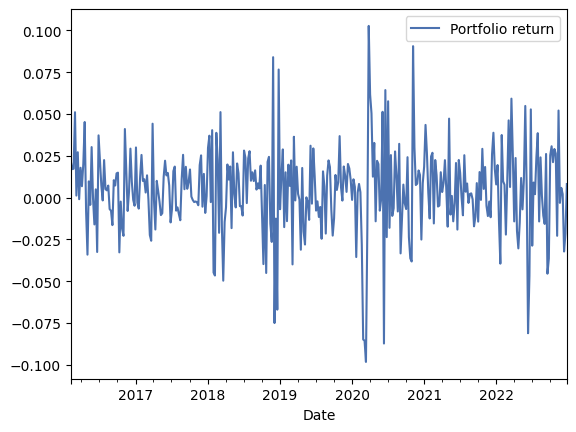

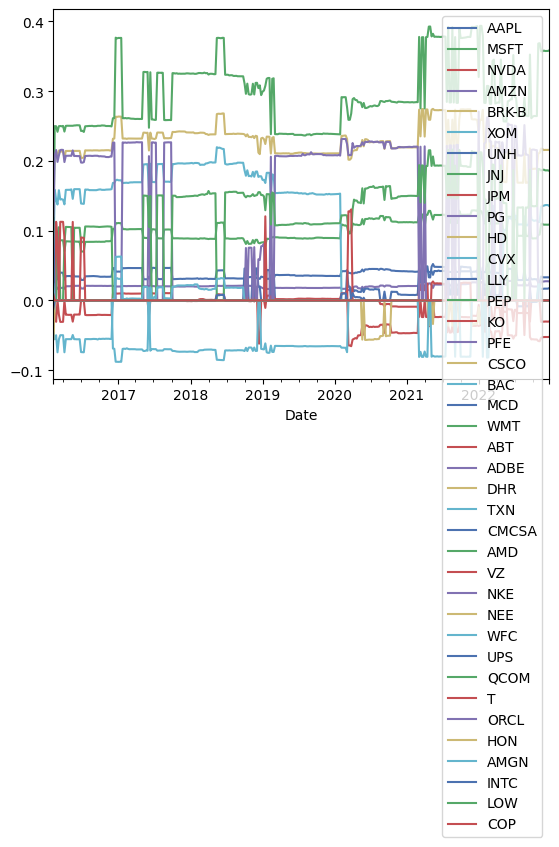

In [ ]:
bl_nr_portfolio_weekly = pd.DataFrame(0, index = test_dates_weekly, columns = ['Portfolio return'])
for t in test_dates_weekly:
  bl_nr_portfolio_weekly.loc[t] = np.dot(bl_weights_nr_weekly.loc[t], returns_weekly.loc[t])

bl_nr_portfolio_weekly.plot()
bl_nr_portfolio_weekly.mean()

bl_weights_nr_weekly.plot()

In [ ]:
sr_nr_weekly = sharpe_ratio(bl_nr_portfolio_weekly, N_weekly, riskfree_weekly['Weekly'].iloc[840:])
print(sr_nr_weekly)

mean Portfolio return    0.226569
dtype: float64 stdv Portfolio return    0.185281
dtype: float64
Portfolio return    1.167603
dtype: float64


Relative Naive Daily

In [ ]:
window_size = 200
train_fraction = 0.7
N_daily = 252
x = 10

test_dates_daily = prices_daily.index[round(train_fraction*len(prices_daily.index))+1:]

In [ ]:
bl_weights_nr_daily = pd.DataFrame(index = test_dates_daily, columns = tickers)
count = 0
nr_uncertainty_daily['Average'] = pd.Series(0)
nr_uncertainty_daily['Average'] = nr_uncertainty_daily.mean(axis=1)

for t in bl_weights_nr_daily.index:
  tops = tickers
  if count > 0:
    ago = bl_weights_nr_daily.index.tolist()[bl_weights_nr_daily.index.get_loc(t) - 1]
    interest = nearest(mcaps_new.index.tolist(), ago)
    tops = top_x_mc(mcaps_new, interest, x)
  view = nr_daily.loc[t]
  view_cov = np.array(nr_uncertainty_daily['Average'].loc[t])
  view_cov = np.array([view_cov]).reshape(-1, 1)
  P = P_daily[tops].loc[t].to_frame()
  count = count+1
  bl_weights_nr_daily.loc[t] = bl_weights_rel(t, view, view_cov, P.transpose(), window_size, riskfree_daily['Daily '].iloc[bl_weights_nr_daily.index.get_loc(t)-1], 
                                            prices_daily[tops], market_prices_daily[:t], mcaps_new[tops].loc[nearest(mcaps_new.index.tolist(), t)], N_daily)
  
  bl_weights_nr_daily = bl_weights_nr_daily.fillna(0)

<Axes: xlabel='Date'>

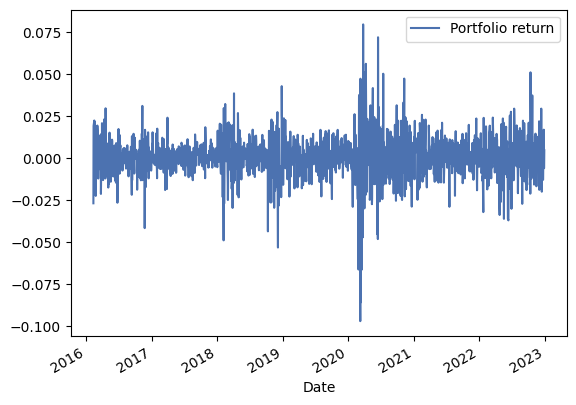

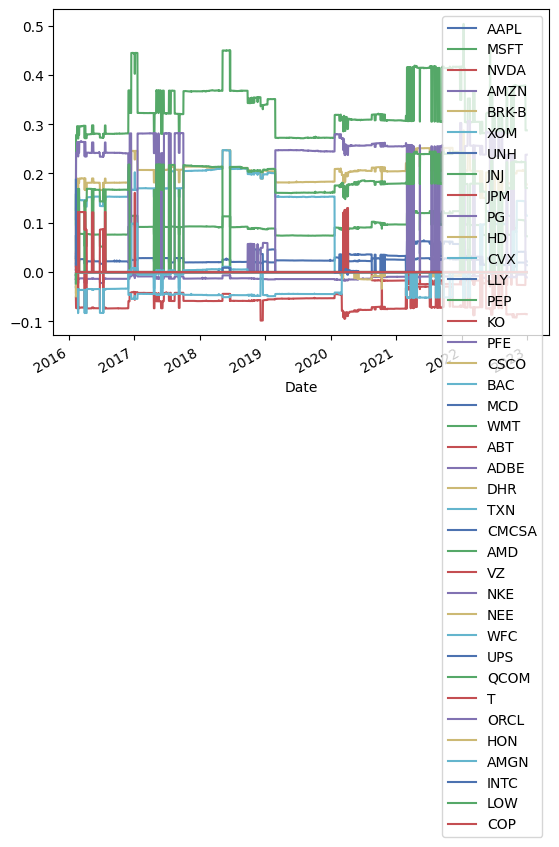

In [ ]:
bl_nr_portfolio_daily = pd.DataFrame(0, index = test_dates_daily, columns = ['Portfolio return'])
for t in test_dates_daily:
  bl_nr_portfolio_daily.loc[t] = np.dot(bl_weights_nr_daily.loc[t], returns_daily.loc[t])

bl_nr_portfolio_daily.plot()
bl_nr_portfolio_daily.mean()

bl_weights_nr_daily.plot()

In [ ]:
sr_nr_daily = sharpe_ratio(bl_nr_portfolio_daily, N_daily, riskfree_daily['Daily '].iloc[3510:])
print(sr_nr_daily)

mean Portfolio return    0.185084
dtype: float64 stdv Portfolio return    0.195794
dtype: float64
Portfolio return    0.944921
dtype: float64
